In [228]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import copy
import random
import warnings
from sklearn import linear_model
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

random.seed(42)

In [229]:
df = pd.read_csv('../data/data.csv',index_col=0)
df1 = copy.deepcopy(df) 

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 410 entries, 2020-03-03 to 2021-04-16
Data columns (total 27 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   CASE_COUNT                                          410 non-null    int64  
 1   PROBABLE_CASE_COUNT                                 410 non-null    int64  
 2   CASE_COUNT_7DAY_AVG                                 410 non-null    int64  
 3   ALL_CASE_COUNT_7DAY_AVG                             410 non-null    int64  
 4   DEATH_COUNT                                         410 non-null    int64  
 5   PROBABLE_DEATH_COUNT                                410 non-null    int64  
 6   DEATH_COUNT_7DAY_AVG                                410 non-null    int64  
 7   ALL_DEATH_COUNT_7DAY_AVG                            410 non-null    int64  
 8   TOTAL_TESTS                                         410 non-null    i

In [231]:
df = df.astype(float)

In [232]:
scaler = StandardScaler()
scaler = scaler.fit(df)
df_train = scaler.transform(df)

In [233]:
def set_shape(fut):
    trainX = []
    trainY = []
    n_future = fut  # Number of days we want to predict into the future
    n_past = 7     # Number of past days we want to use to predict the future

    for i in range(n_past, len(df_train) - n_future +1):
        trainX.append(df_train[i - n_past:i, 0:df_train.shape[1]])
        trainY.append(df_train[i + n_future - 1:i + n_future, 0])

    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))
    return trainX,trainY

In [234]:

def test_train_split(trainX, trainY):
    testX = trainX[-60:]
    testY = trainY[-60:]

    trainX = trainX[:-60]
    trainY = trainY[:-60]

    trainDates = df1.index[:-60]
    testDates = df1.index[-60:]

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))

    print('testX shape == {}.'.format(testX.shape))
    print('testY shape == {}.'.format(testY.shape))
    return testX,testY,trainDates,testDates,trainX,trainY

In [235]:
def plot(classifiers_names, evaluation):
    fig, axs = plt.subplots(1,3, figsize=(20, 5))
    axs = axs.ravel()

    # print(classifiers_names)

    for i in range(3):
        axs[i].bar(classifiers_names,evaluation[i])
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(90)
    axs[0].set_title('MSE')
    axs[1].set_title('MAE')
    axs[2].set_title('R2')
    plt.show()

In [236]:
def predict_n_days(trainX, trainY, testX, testY, testDates,n):

    classifiers = [
        svm.SVR(),
        linear_model.ARDRegression(),
        RandomForestRegressor(random_state = 42),
        GradientBoostingRegressor(random_state=42),
        linear_model.SGDRegressor(random_state=42),
        linear_model.LinearRegression()]

    nsamples, nx, ny = trainX.shape
    train_new_dataset = trainX.reshape((nsamples,nx*ny))
    nsamples, nx, ny = testX.shape
    test_new_dataset = testX.reshape((nsamples,nx*ny))


    df1['Date'] = pd.to_datetime(df1.index)

    fig, axs = plt.subplots(2,3, figsize=(30, 15))
    fig.suptitle(f'Predicting {n} day(s) ahead in the future',fontsize=30)
    classifiers_names = ['svm','ARDRegression','RandomForestRegressor','GradientBoostingRegressor','SGDRegressor','LinearRegression']

    MSE_scores = []
    MAE_scores = []
    R2_scores = []

    axs = axs.ravel()   

    i=0
    for item in classifiers:
        clf = item
        clf.fit(train_new_dataset, trainY.ravel())
        forecast = (clf.predict(test_new_dataset))
        forecast = forecast.reshape(len(forecast), 1, 1)
        forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
        y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
        y_pred_future = y_pred_future[:,0]
        df_forecast = pd.DataFrame({'Date':testDates, 'Cases':y_pred_future})
        df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
        axs[i].set_title(classifiers_names[i])
        axs[i].set_ylabel('Cases')
        testY_new = scaler.inverse_transform(np.repeat(testY,df_train.shape[1], axis=-1))[:,0]
        axs[i].plot(df_forecast['Date'], testY_new)
        axs[i].plot(df_forecast['Date'], df_forecast['Cases'])
        for tick in axs[i].get_xticklabels():
            tick.set_rotation(45)
        i+=1
        R2_scores.append(r2_score(testY,forecast.reshape(len(forecast),1)))
        MSE_scores.append(mean_squared_error(testY,forecast.reshape(len(forecast),1)))
        MAE_scores.append(mean_absolute_error(testY,forecast.reshape(len(forecast),1)))

    print([f"{num:.5f}" for num in R2_scores])
    print([f"{num:.5f} & " for num in MSE_scores])
    print([f"{num:.5f} &" for num in MAE_scores])

    plt.show()
    evaluation = [MSE_scores,MAE_scores,R2_scores]
    plot(classifiers_names, evaluation)

trainX shape == (403, 7, 27).
trainY shape == (403, 1).
trainX shape == (343, 7, 27).
trainY shape == (343, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).
['0.66977', '0.48376', '0.46112', '0.44985', '0.56829', '-0.97958']
['0.05324', '0.08323', '0.08688', '0.08869', '0.06960', '0.31914']
['0.17615', '0.22720', '0.24284', '0.24944', '0.21999', '0.42545']


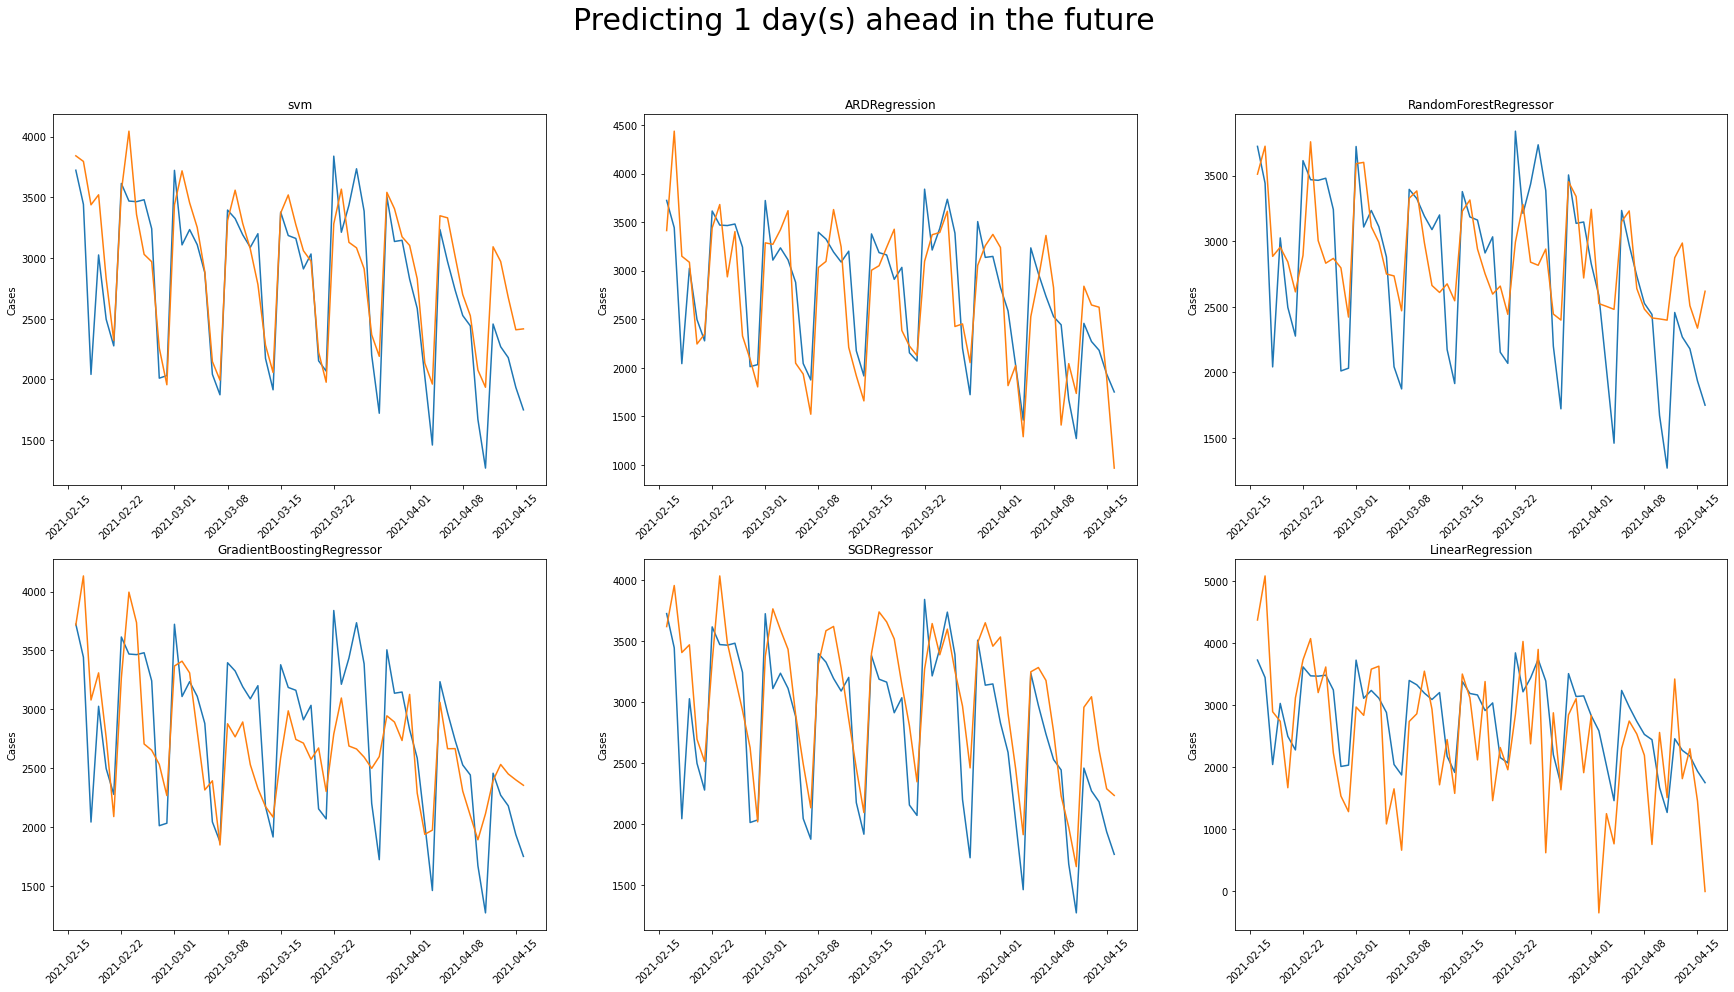

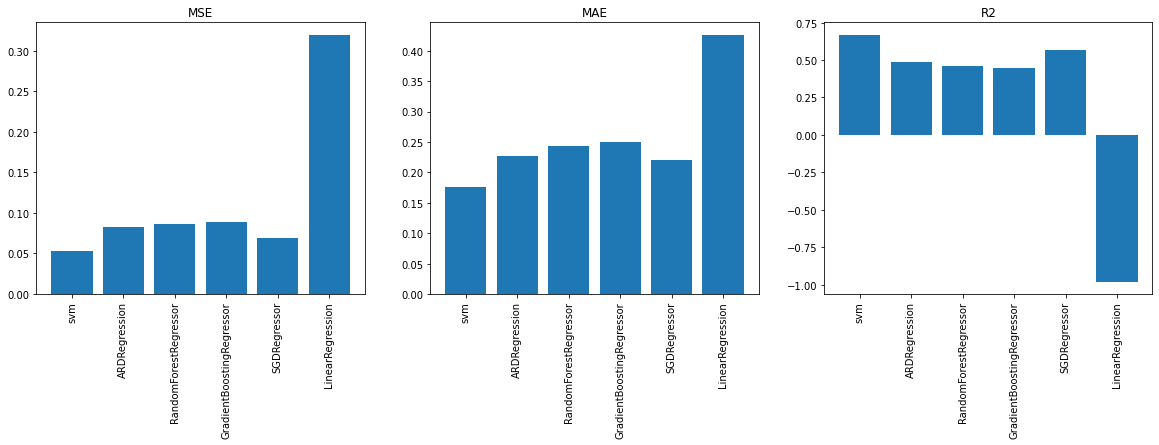

trainX shape == (402, 7, 27).
trainY shape == (402, 1).
trainX shape == (342, 7, 27).
trainY shape == (342, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).
['0.47136', '0.54786', '0.35911', '0.38275', '0.24436', '-1.32936']
['0.08522', '0.07289', '0.10332', '0.09951', '0.12182', '0.37553']
['0.23663', '0.21202', '0.25754', '0.24614', '0.29486', '0.50959']


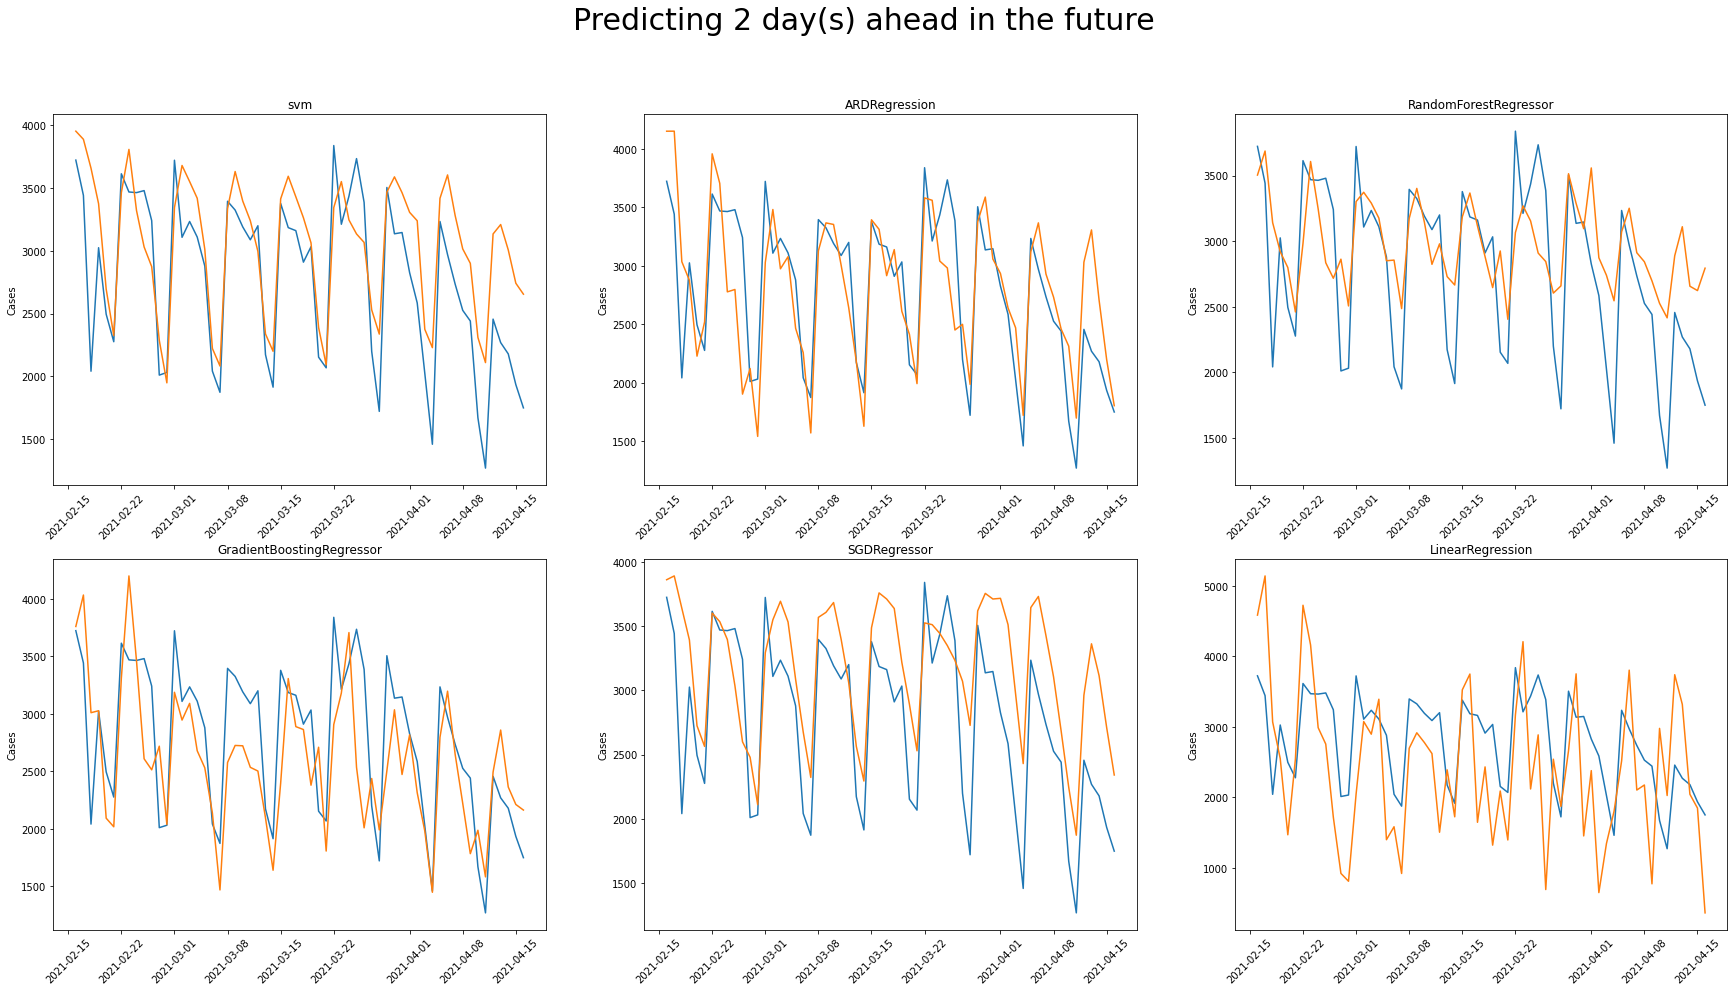

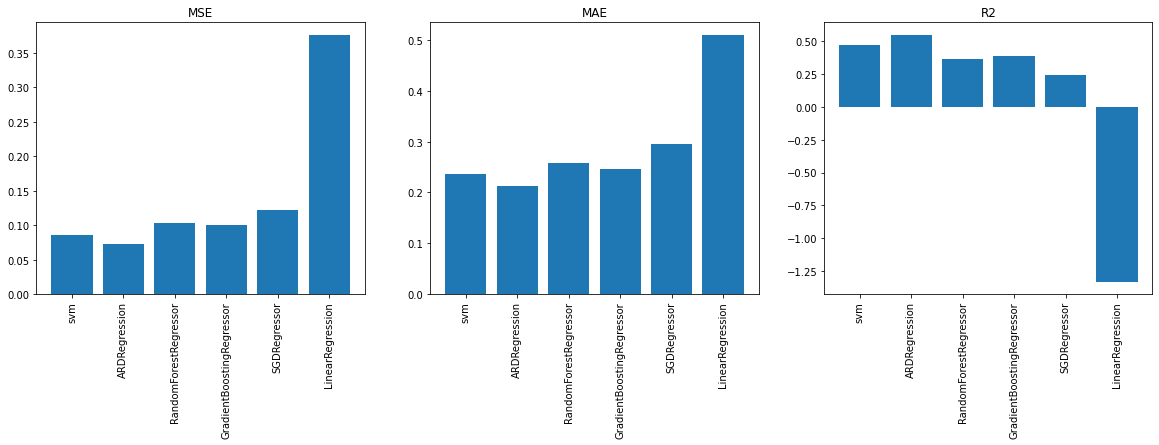

trainX shape == (401, 7, 27).
trainY shape == (401, 1).
trainX shape == (341, 7, 27).
trainY shape == (341, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).
['0.18115', '0.28784', '0.23751', '0.30467', '-0.15059', '-1.15995']
['0.13201', '0.11481', '0.12292', '0.11210', '0.18549', '0.34822']
['0.30005', '0.27463', '0.28711', '0.27406', '0.37590', '0.47509']


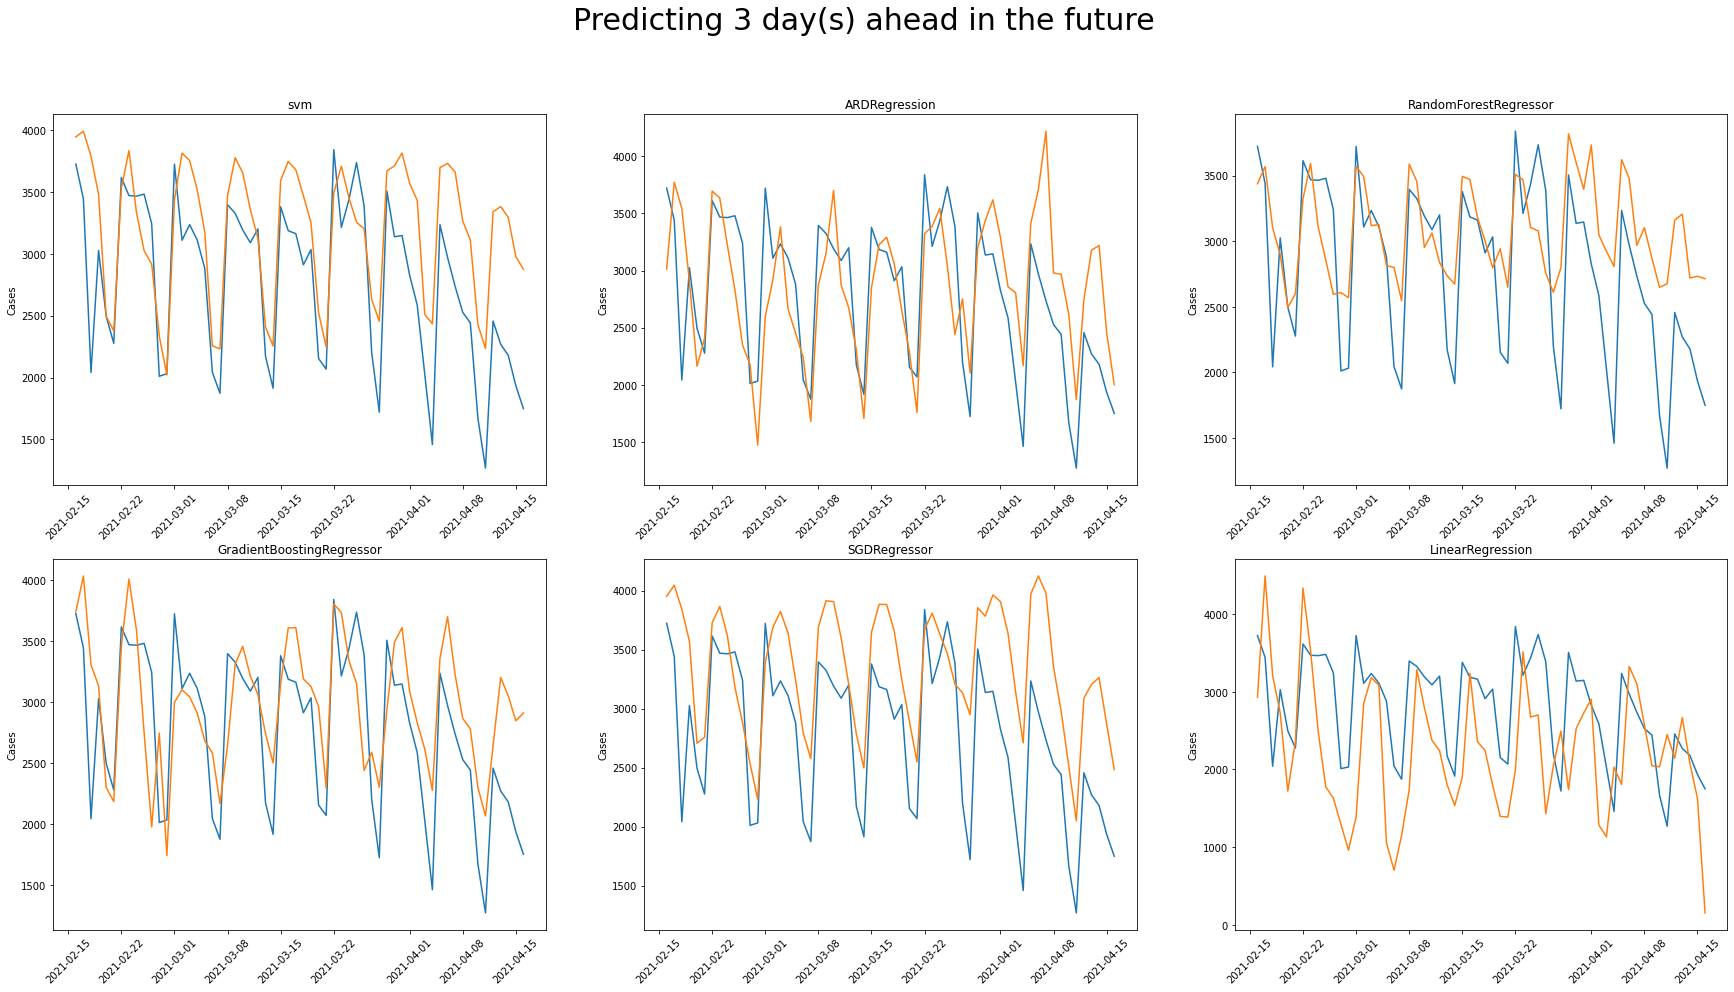

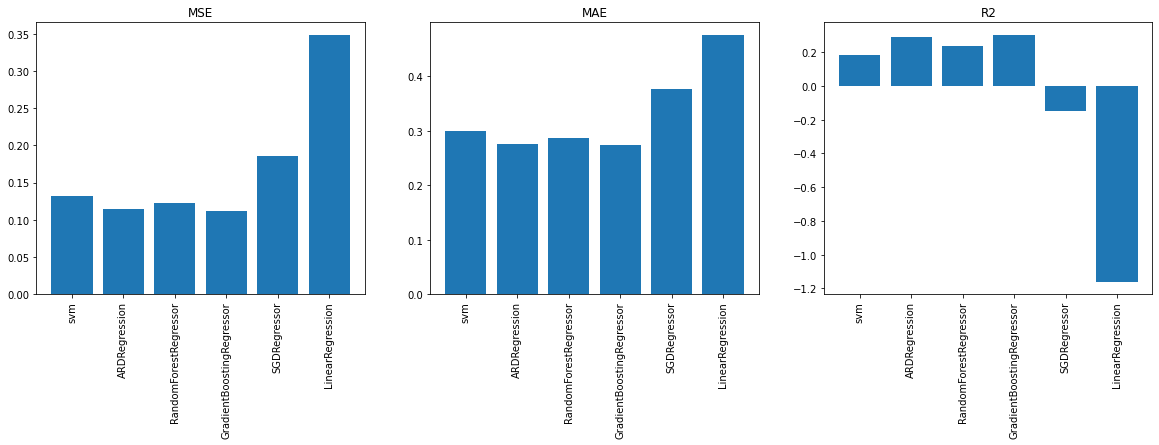

trainX shape == (400, 7, 27).
trainY shape == (400, 1).
trainX shape == (340, 7, 27).
trainY shape == (340, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).
['-0.14321', '0.06788', '0.18569', '0.49359', '0.06036', '-1.28491']
['0.18430', '0.15027', '0.13128', '0.08164', '0.15148', '0.36836']
['0.36192', '0.30748', '0.30318', '0.21971', '0.33656', '0.51561']


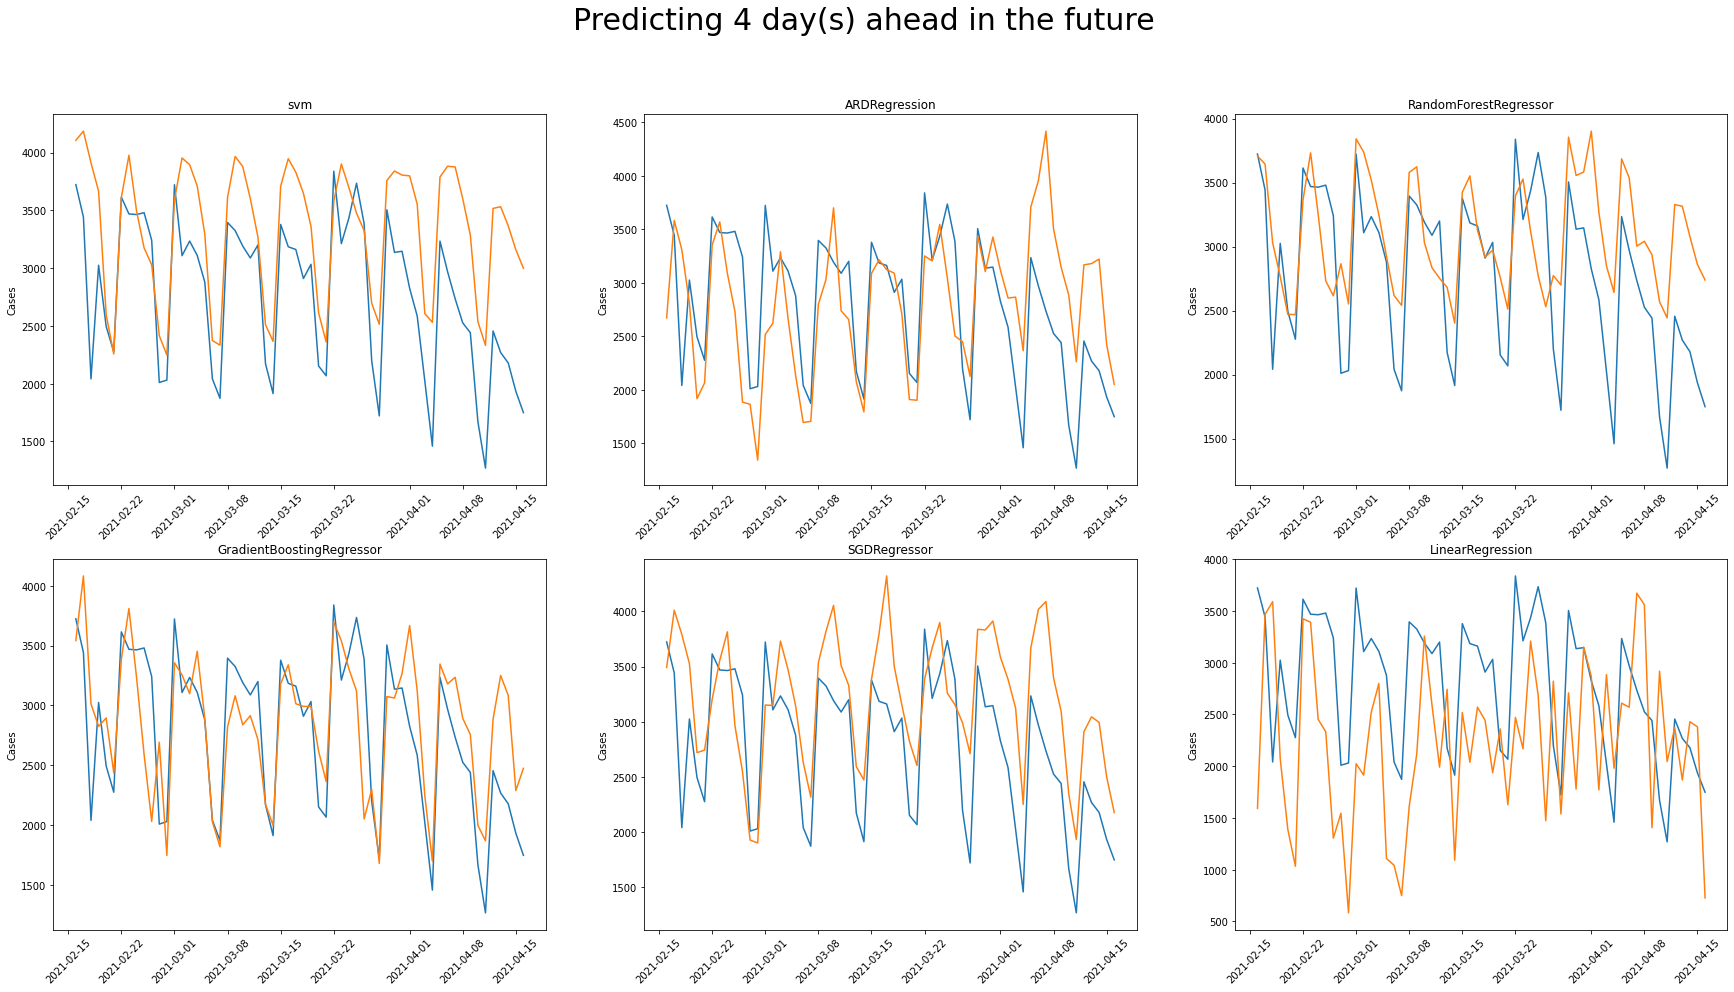

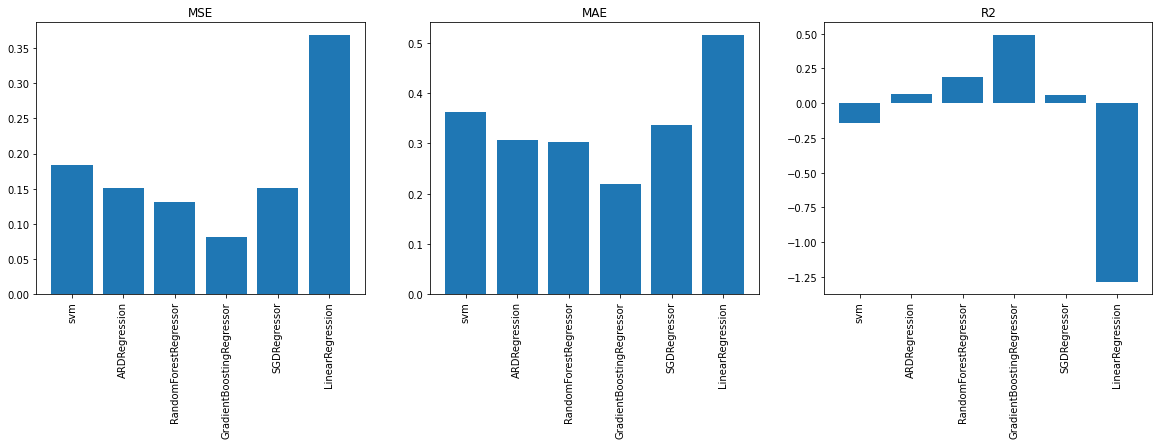

trainX shape == (399, 7, 27).
trainY shape == (399, 1).
trainX shape == (339, 7, 27).
trainY shape == (339, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).
['-0.56157', '0.02857', '0.13129', '0.05533', '-0.42911', '-1.28551']
['0.25175', '0.15661', '0.14005', '0.15230', '0.23039', '0.36846']
['0.42617', '0.30025', '0.30862', '0.33327', '0.39824', '0.49541']


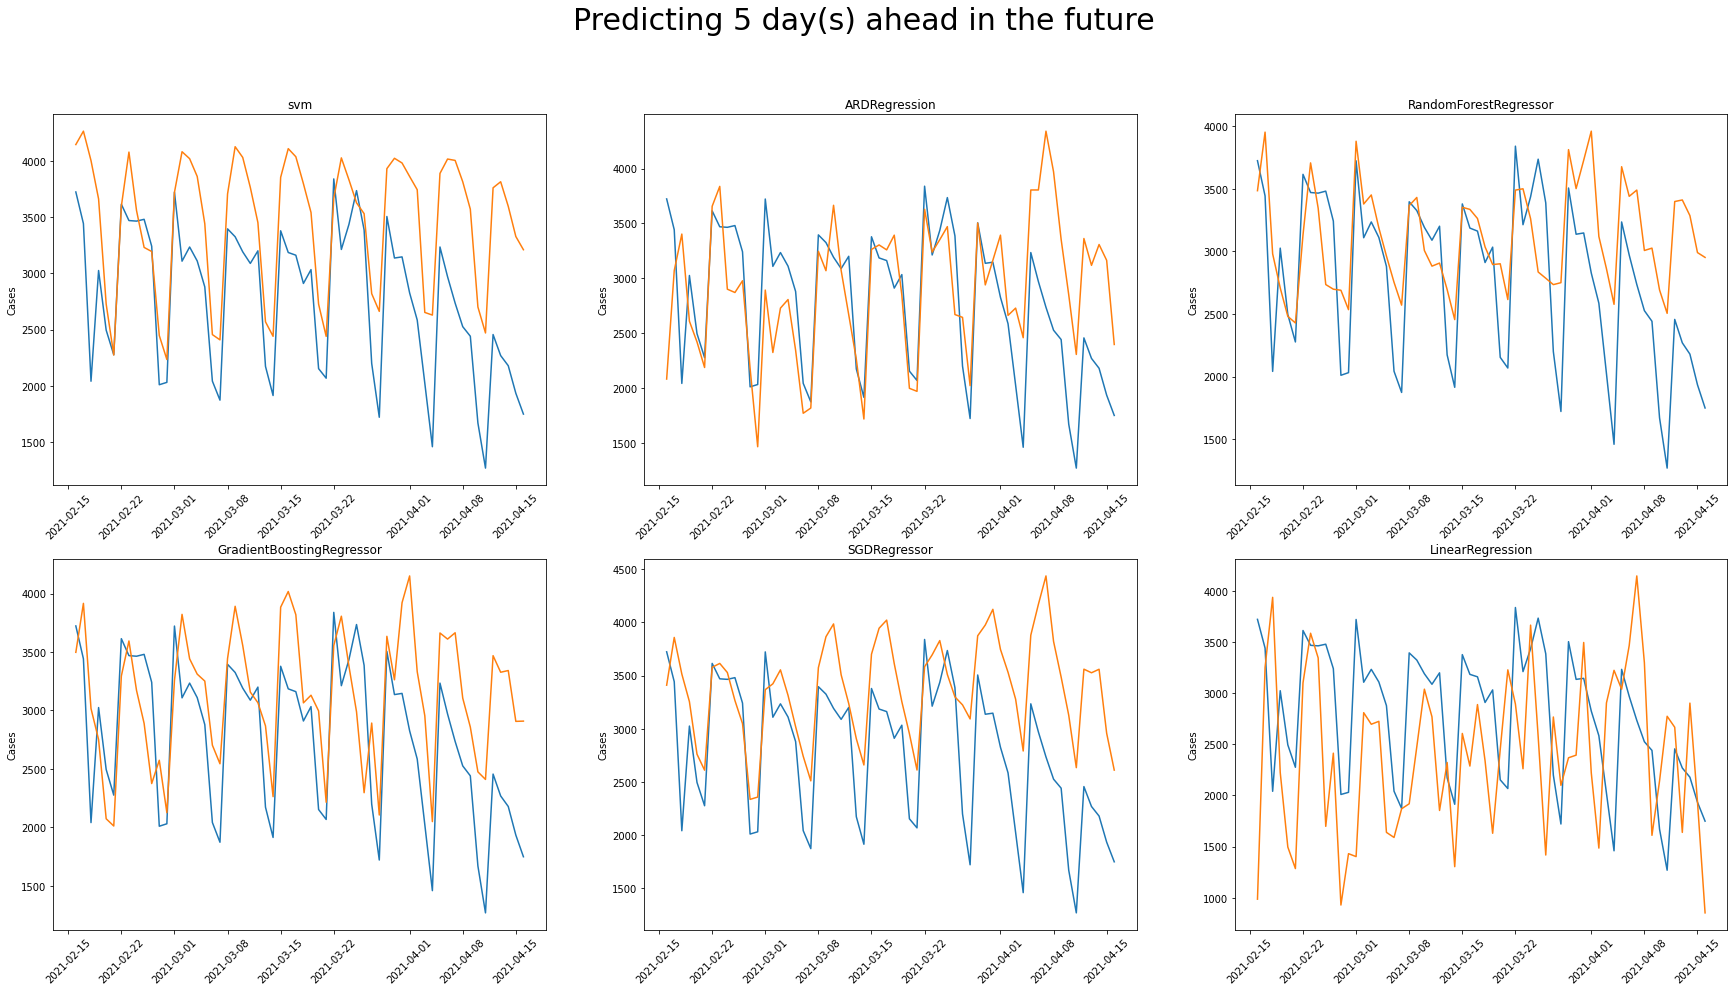

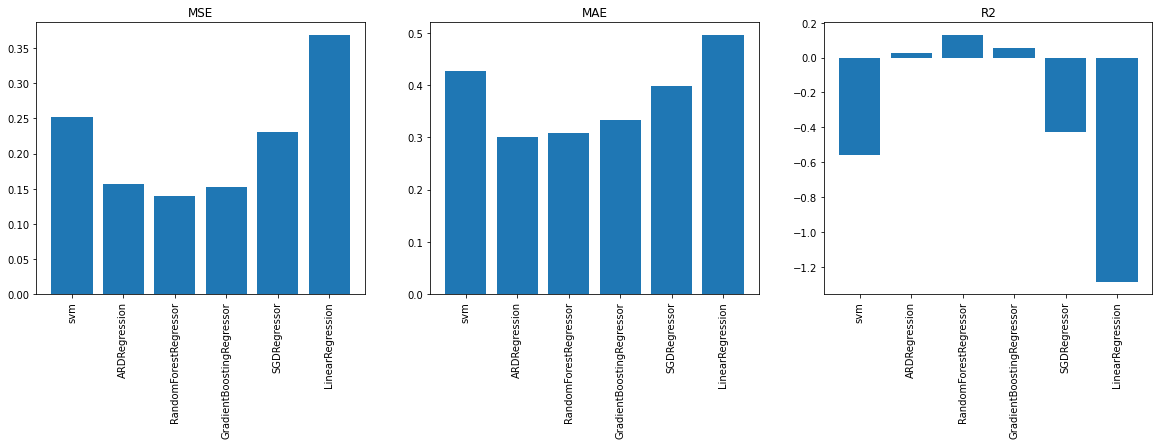

trainX shape == (398, 7, 27).
trainY shape == (398, 1).
trainX shape == (338, 7, 27).
trainY shape == (338, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).
['-0.83036', '-0.12586', '0.02753', '-0.81896', '-0.84298', '-1.06387']
['0.29508', '0.18150', '0.15678', '0.29324', '0.29712', '0.33273']
['0.47013', '0.32341', '0.32719', '0.46402', '0.46736', '0.44117']


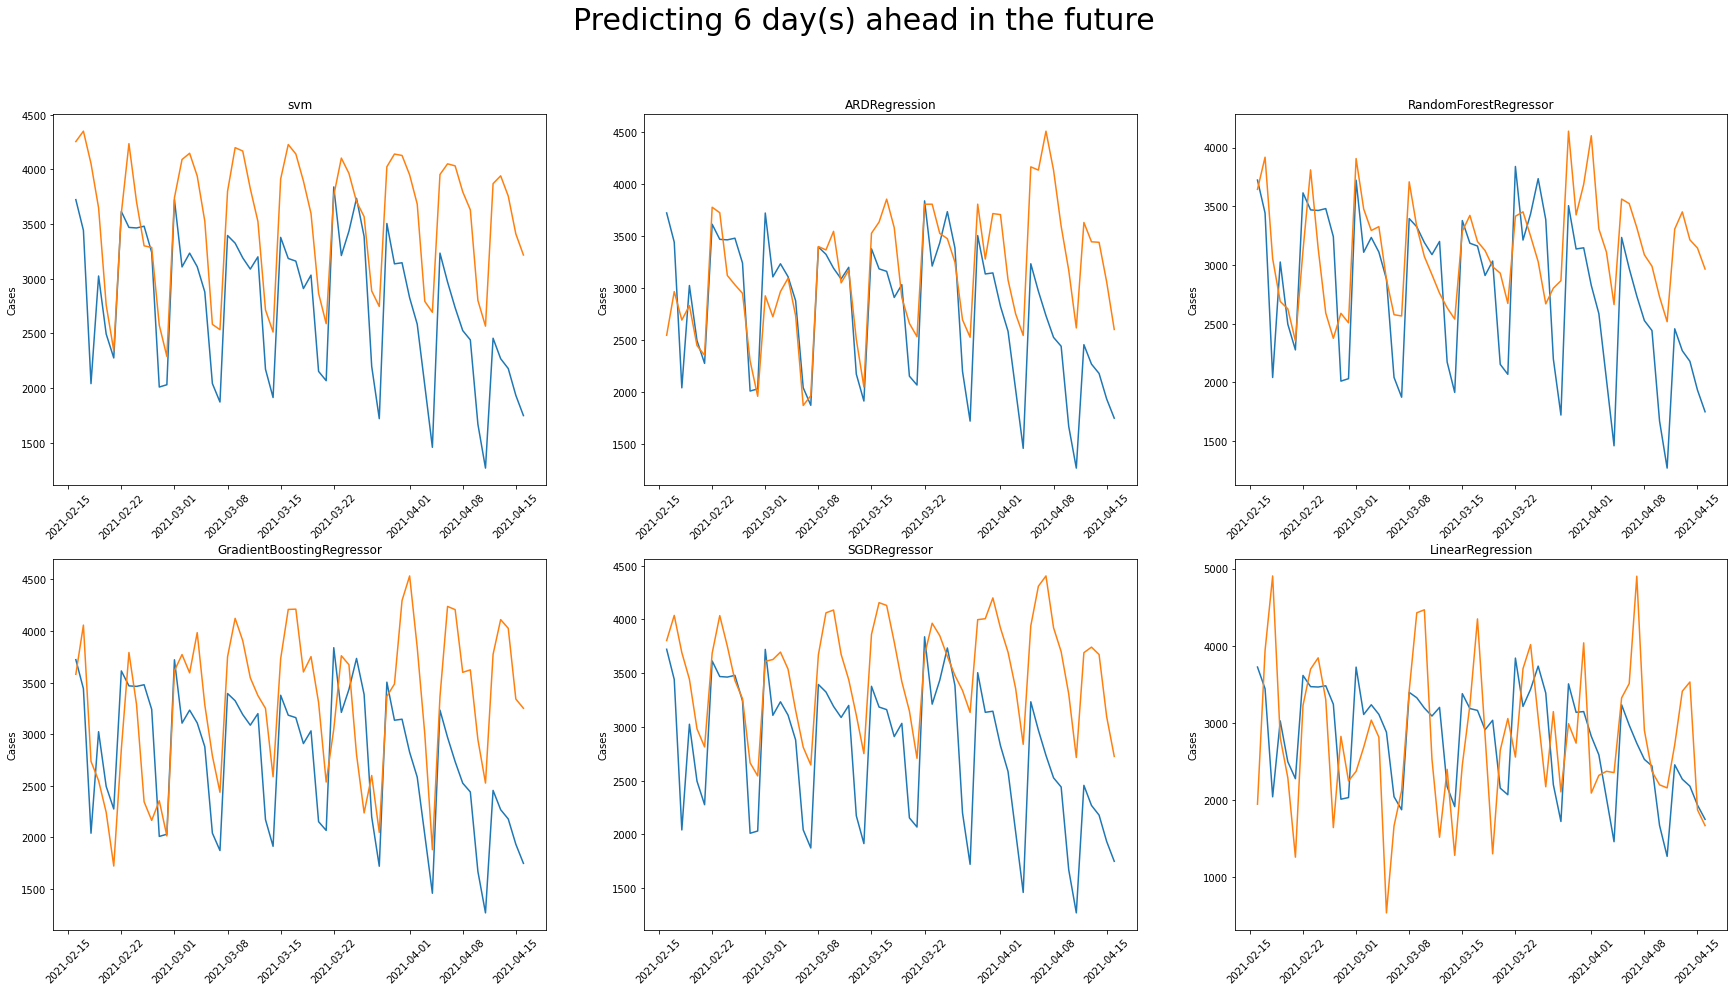

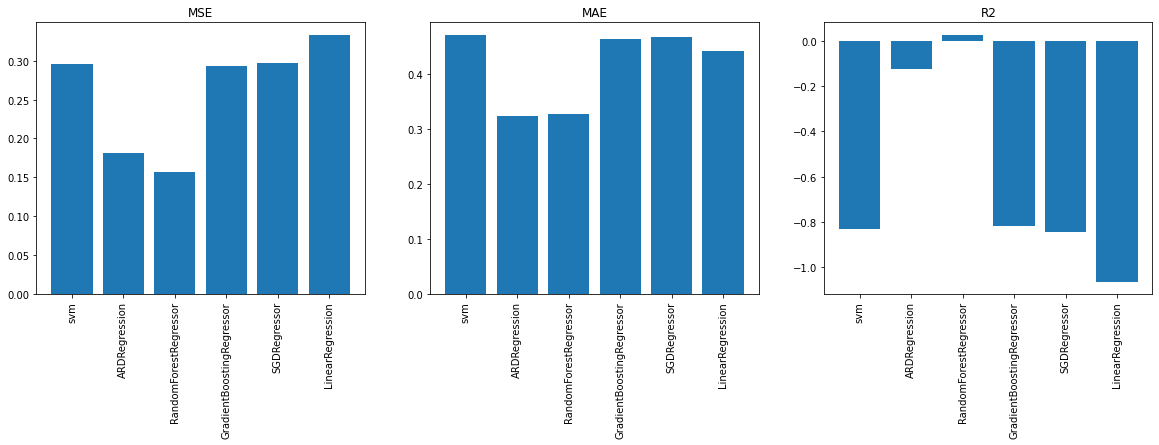

trainX shape == (397, 7, 27).
trainY shape == (397, 1).
trainX shape == (337, 7, 27).
trainY shape == (337, 1).
testX shape == (60, 7, 27).
testY shape == (60, 1).
['-0.78608', '0.27080', '0.04629', '-1.34171', '-0.48858', '-4.07222']
['0.28794', '0.11756', '0.15375', '0.37752', '0.23998', '0.81772']
['0.46838', '0.28463', '0.31675', '0.53654', '0.41017', '0.71479']


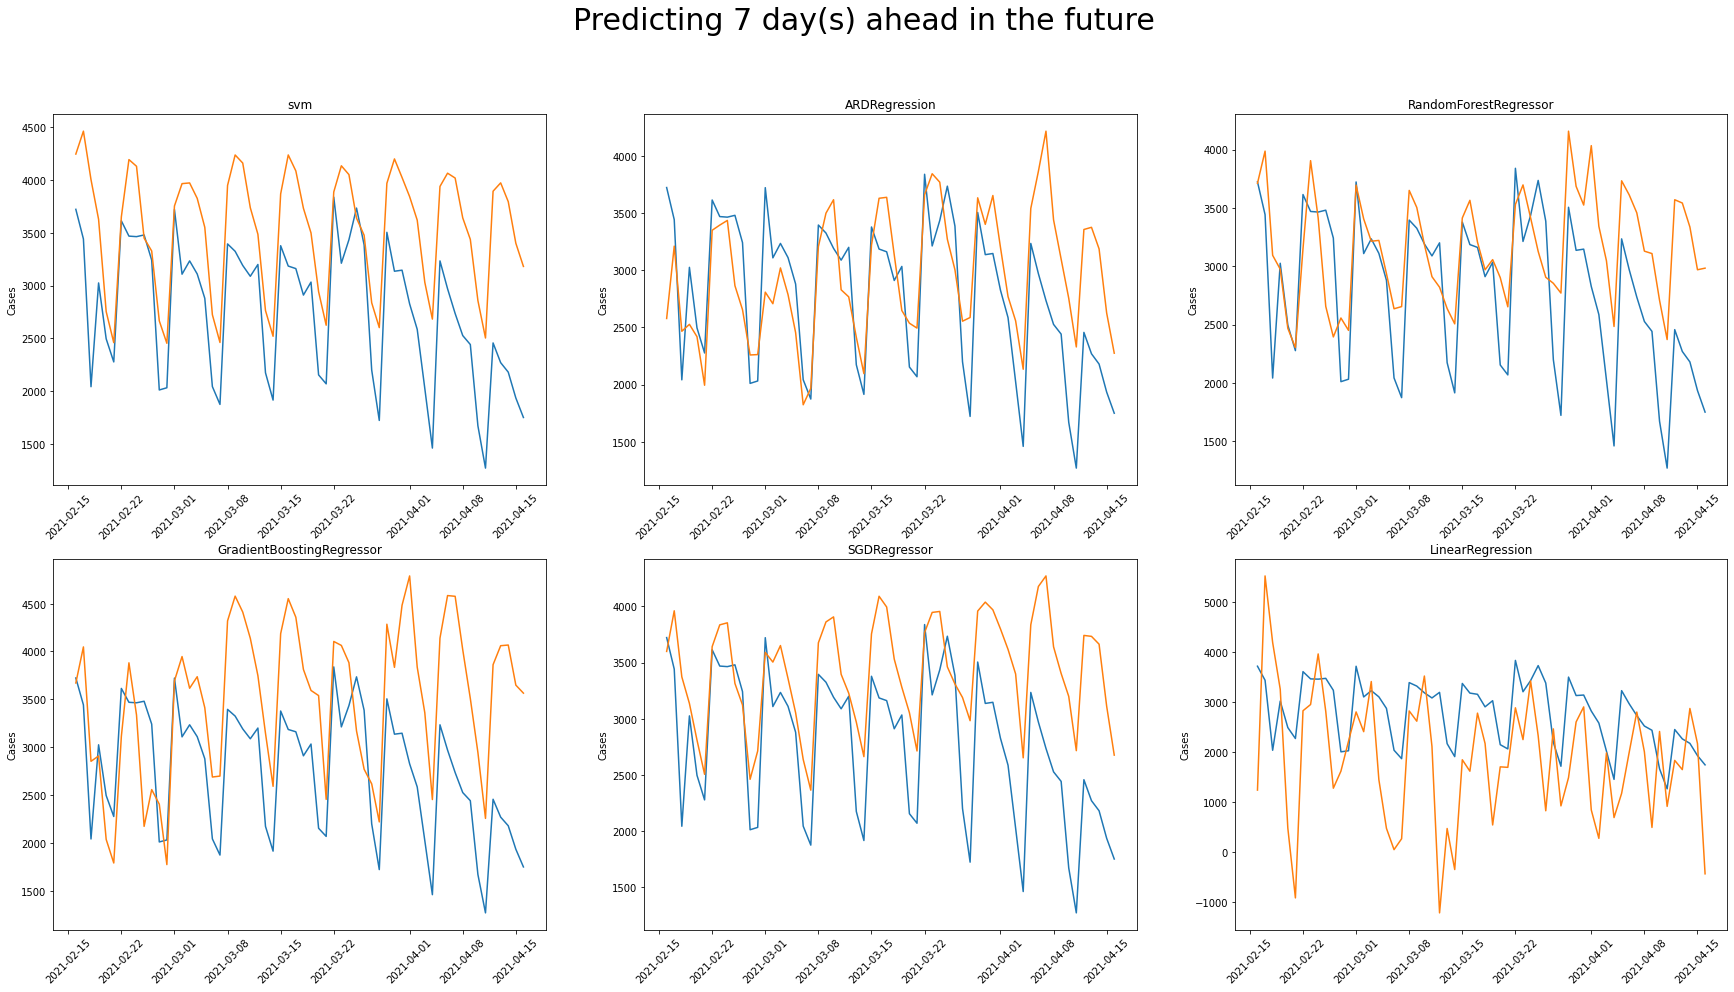

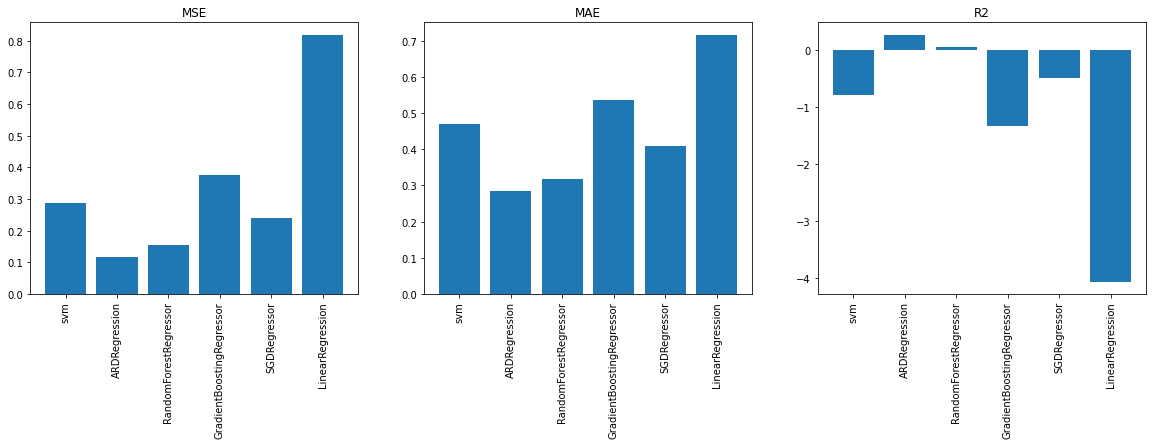

In [237]:
for i in range(1,8):
    trainX_new, trainY_new = set_shape(i)
    testX_new, testY_new,trainDates, testDates, trainX_new,trainY_new = test_train_split(trainX_new, trainY_new)
    predict_n_days(trainX_new, trainY_new, testX_new, testY_new, testDates,i)